# Exploratory Data Analysis

This notebook focuses on performing exploratory data analysis on the credit card fraud dataset found on [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The features labeled `V1` to `V28` are the result of an unknown PCA transformation for privacy reasons. It is not clear if these are the full set of features or if only the top 28 features were included. My assumption is that these are the top 28 features after the PCA transformation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
FIGSIZE = (8, 6)

After loading the data, it is useful to look at the data as well as the summary statistics for each feature using pandas `describe()` method. For features `V1` to `V28`, the distributions are centered at 0 with a standard deviation on the order of 1. `Time` and `Amount` are clearly not scaled and require some preprocessing. The class imbalance can be seen in the summary of `Class` showing that the anomalous (positive) class is only 0.17% of the data. Additionally, it's important to check for missing values in the data. In this case, there are no missing values.

In [32]:
df = pd.read_csv('data/creditcard.csv')
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

In [12]:
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [15]:
# Examine the class imbalance in the data set
print(f'Fraud: {(df.Class.sum() / df.shape[0]) * 100:.2f}%')
print(f'Non-fraud: {(1 - (df.Class.sum() / df.shape[0])) * 100:.2f}%')

Fraud: 0.17%
Non-fraud: 99.83%


In [16]:
# Check for NaNs in any column
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

It's useful to see how each class is distributed per feature. Most features show a roughly Gaussian distribution for the normal instances while the anomalous instances tend to be broader with long tails on one side.

For `Time` and `Amount` it is obvious that scaling needs to be performed. `Time` might also benefit from restructuring to time-of-day, possibly in hour intervals, prior to scaling. These would be relative times as the time is referenced from the first row of data.

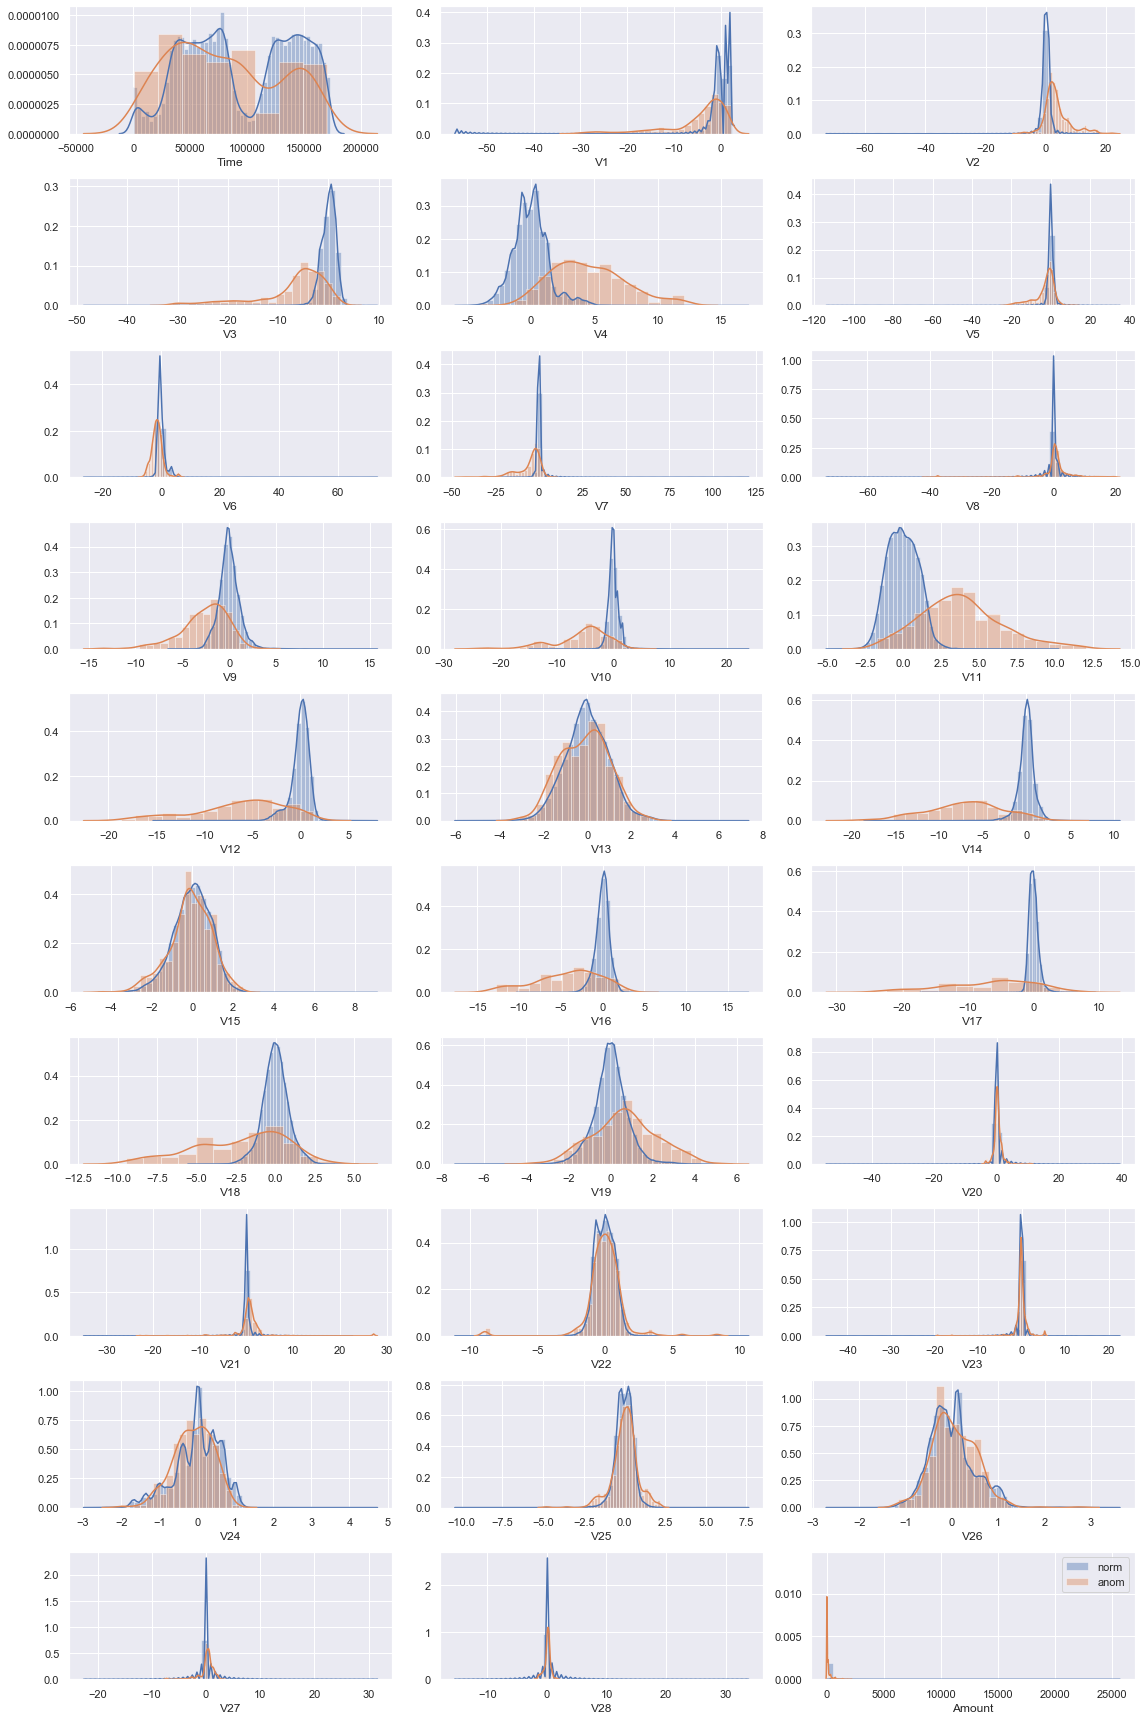

In [12]:
r, c = 0, 0
fig, axes = plt.subplots(10, 3, figsize=(16,24))
for col in df.columns:
    if col in 'Class':
        continue
    if c == 3:
        r += 1
        c = 0
    norm = df.loc[df.Class == 0, col]
    anom = df.loc[df.Class == 1, col]
    sns.distplot(norm, label='norm', ax=axes[r, c])
    sns.distplot(anom, label='anom', ax=axes[r, c])
    c += 1

plt.legend()  
plt.tight_layout()
plt.show()

It's also interesting to compare the mean and maximum `Amount` for normal and anomalous data. The normal instances have a lower mean but higher maximum compared to the anomalous data.

In [25]:
print(df.loc[df.Class == 0, 'Amount'].describe())
print(df.loc[df.Class == 1, 'Amount'].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [33]:
# Transform raw time to hour of the day
# Time starts at 0 and is recorded in seconds since t0
df.loc[:, 'hour_of_day'] = df.Time.apply(lambda x: x // (60 * 60))
day_2_idx = df.hour_of_day > 23.0
df.loc[day_2_idx, 'hour_of_day'] = df.loc[day_2_idx, 'hour_of_day'].apply(lambda x: x - 24.0)

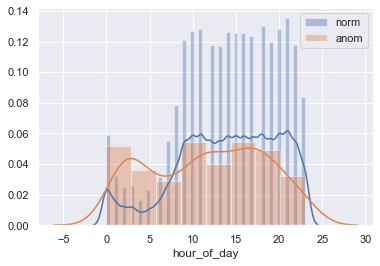

In [34]:
norm = df.loc[df.Class == 0, 'hour_of_day']
anom = df.loc[df.Class == 1, 'hour_of_day']
sns.distplot(norm, label='norm')
sns.distplot(anom, label='anom')
plt.legend()
plt.show()

In [35]:
# Since 'Time' and 'Amount' haven't been scaled and transformed in PCA,
# these need to be similarly scaled as the other features
s_scaler = StandardScaler()
r_scaler = RobustScaler() # Robust to outliers

amounts = df.Amount.values.reshape(-1,1)
#times = df.Time.values.reshape(-1,1)
times = df.hour_of_day.values.reshape(-1,1)
df.loc[:, 'scaled_amount'] = r_scaler.fit_transform(amounts)
df.loc[:, 'scaled_time'] = s_scaler.fit_transform(times)

#df.drop(['Time', 'Amount'], axis=1, inplace=True)

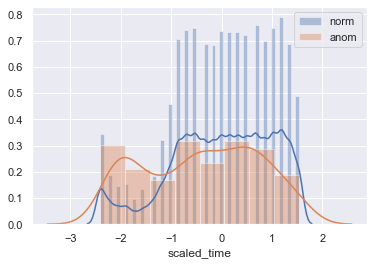

In [38]:
norm = df.loc[df.Class == 0, 'scaled_time']
anom = df.loc[df.Class == 1, 'scaled_time']
sns.distplot(norm, label='norm')
sns.distplot(anom, label='anom')
plt.legend()
plt.show()

In [36]:
print(df.loc[df.Class == 0, 'scaled_amount'].describe())
print(df.loc[df.Class == 1, 'scaled_amount'].describe())

count    284315.000000
mean          0.926305
std           3.494796
min          -0.307413
25%          -0.228464
50%           0.000000
75%           0.769231
max         358.683155
Name: scaled_amount, dtype: float64
count    492.000000
mean       1.400284
std        3.586715
min       -0.307413
25%       -0.293440
50%       -0.178160
75%        1.172221
max       29.398030
Name: scaled_amount, dtype: float64


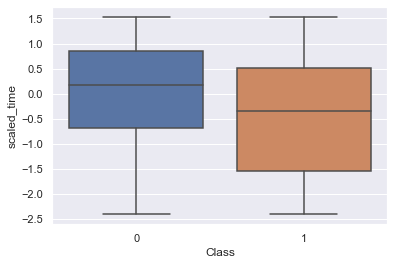

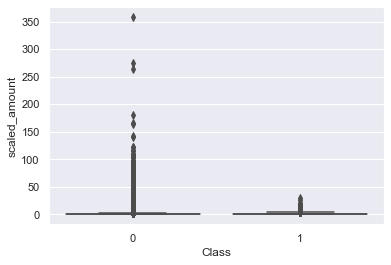

In [37]:
for col in ['scaled_time', 'scaled_amount']:
    norm = df.loc[df.Class == 0, col]
    anom = df.loc[df.Class == 1, col]
    sns.boxplot(x='Class', y=col, data=df)
    #sns.distplot(norm, label='norm')
    #sns.distplot(anom, label='anom')
    plt.show()

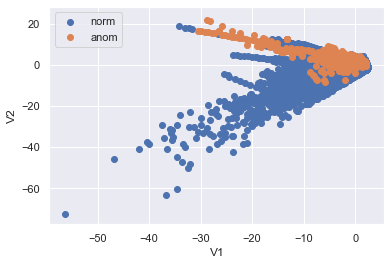

In [40]:
# Assuming columns are sorted based on PCA, look at V1 vs V2
plt.scatter(df.loc[df.Class == 0, 'V1'], df.loc[df.Class == 0, 'V2'], label='norm')
plt.scatter(df.loc[df.Class == 1, 'V1'], df.loc[df.Class == 1, 'V2'], label='anom')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.show()

In [43]:
# Examine correlation for imbalanced, under, and over sampled data
X = df.drop('Class', axis=1).copy()
y = df.Class.copy()

# Under sampling
nm = NearMiss(sampling_strategy='majority', random_state=0)
X_under, y_under = nm.fit_resample(X, y)
df_under = pd.DataFrame(X_under, columns=X.columns)
df_under.loc[:, 'Class'] = y_under

# Over sampling
smote = SMOTE(sampling_strategy='minority', random_state=0)
X_over, y_over = smote.fit_resample(X, y)
df_over = pd.DataFrame(X_over, columns=X.columns)
df_over.loc[:, 'Class'] = y_over

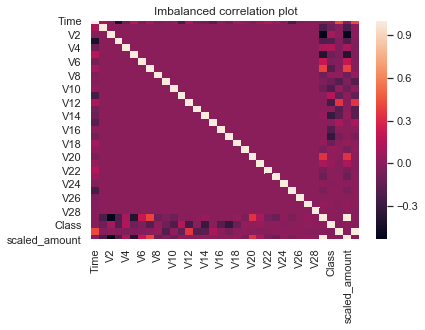

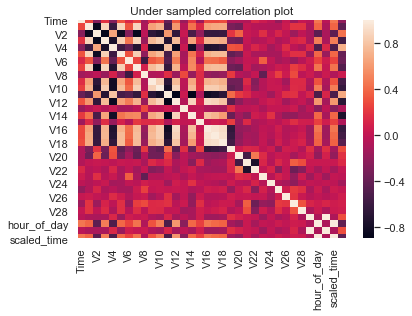

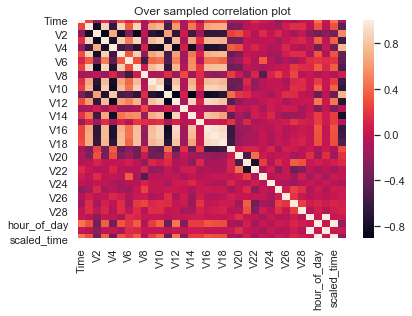

In [44]:
# Imbalanced correlation
sns.heatmap(df.corr())
plt.title('Imbalanced correlation plot')
plt.show()

# Under correlation
sns.heatmap(df_under.corr())
plt.title('Under sampled correlation plot')
plt.show()

# Over correlation
sns.heatmap(df_over.corr())
plt.title('Over sampled correlation plot')
plt.show()

Using the imbalanced data set to examine the correlation of features with `Class` shows that `Time` and `Amount` are the only features with significant correlations. However, looking at the undersampled data where the classes have equal frequency, it's clear that many of the other features have significant correlation with `Class`. The oversampled data shows a similar correlation as the undersampled correlations.

In [49]:
# Examine the sorted correlations from the undersampled data
corrs_under = np.abs(df_under.drop(['Amount', 'hour_of_day', 'Time'], axis=1).corr().Class)
corrs_under = corrs_under.sort_values(ascending=False)
corrs_under = corrs_under.drop('Class')
print(corrs_under)

V14              0.743807
V4               0.708904
V12              0.687433
V11              0.674368
V10              0.628176
V16              0.609048
V3               0.565412
V17              0.560895
V9               0.552070
V7               0.475344
V18              0.462353
V1               0.434300
V2               0.431437
scaled_time      0.425865
V5               0.400317
V6               0.365742
scaled_amount    0.299099
V19              0.289731
V20              0.179094
V21              0.144340
V24              0.133523
V27              0.081835
V13              0.078325
V28              0.069217
V15              0.067698
V26              0.067357
V8               0.056327
V22              0.019454
V25              0.015534
V23              0.011809
Name: Class, dtype: float64


In [50]:
corrs_over = np.abs(df_over.drop(['Amount', 'hour_of_day', 'Time'], axis=1).corr().Class)
corrs_over = corrs_over.sort_values(ascending=False)
corrs_over = corrs_over.drop('Class')
print(corrs_over)

V14              0.788344
V4               0.742580
V11              0.719503
V12              0.711429
V10              0.660799
V16              0.628715
V9               0.598964
V3               0.594577
V17              0.592595
V2               0.528296
V7               0.514555
V18              0.497043
V1               0.456272
V6               0.421859
V5               0.394878
V19              0.296115
scaled_time      0.186031
V20              0.178511
V21              0.140271
V24              0.101180
V28              0.098162
V27              0.084999
V26              0.063704
V8               0.055633
V15              0.055263
V13              0.049240
V25              0.043262
scaled_amount    0.032592
V22              0.008156
V23              0.002717
Name: Class, dtype: float64


Most of the highest correlated features are the same between the under and oversampled data. What's interesting is the higher correlation of `scaled_time` in the undersampled data compared to the oversampled data.